# Learning to Control a Dynamical System

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

## Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

## Instantiate a system emulator from neuromancer.psl

In [21]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
# instantiate simulator model to be controlled
sys = Actuator()

# Define a simple neural ODE model to identify the system from data

In [22]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

# define neural ODE
dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
# model.show()

# Generate datasets representative of system behavior

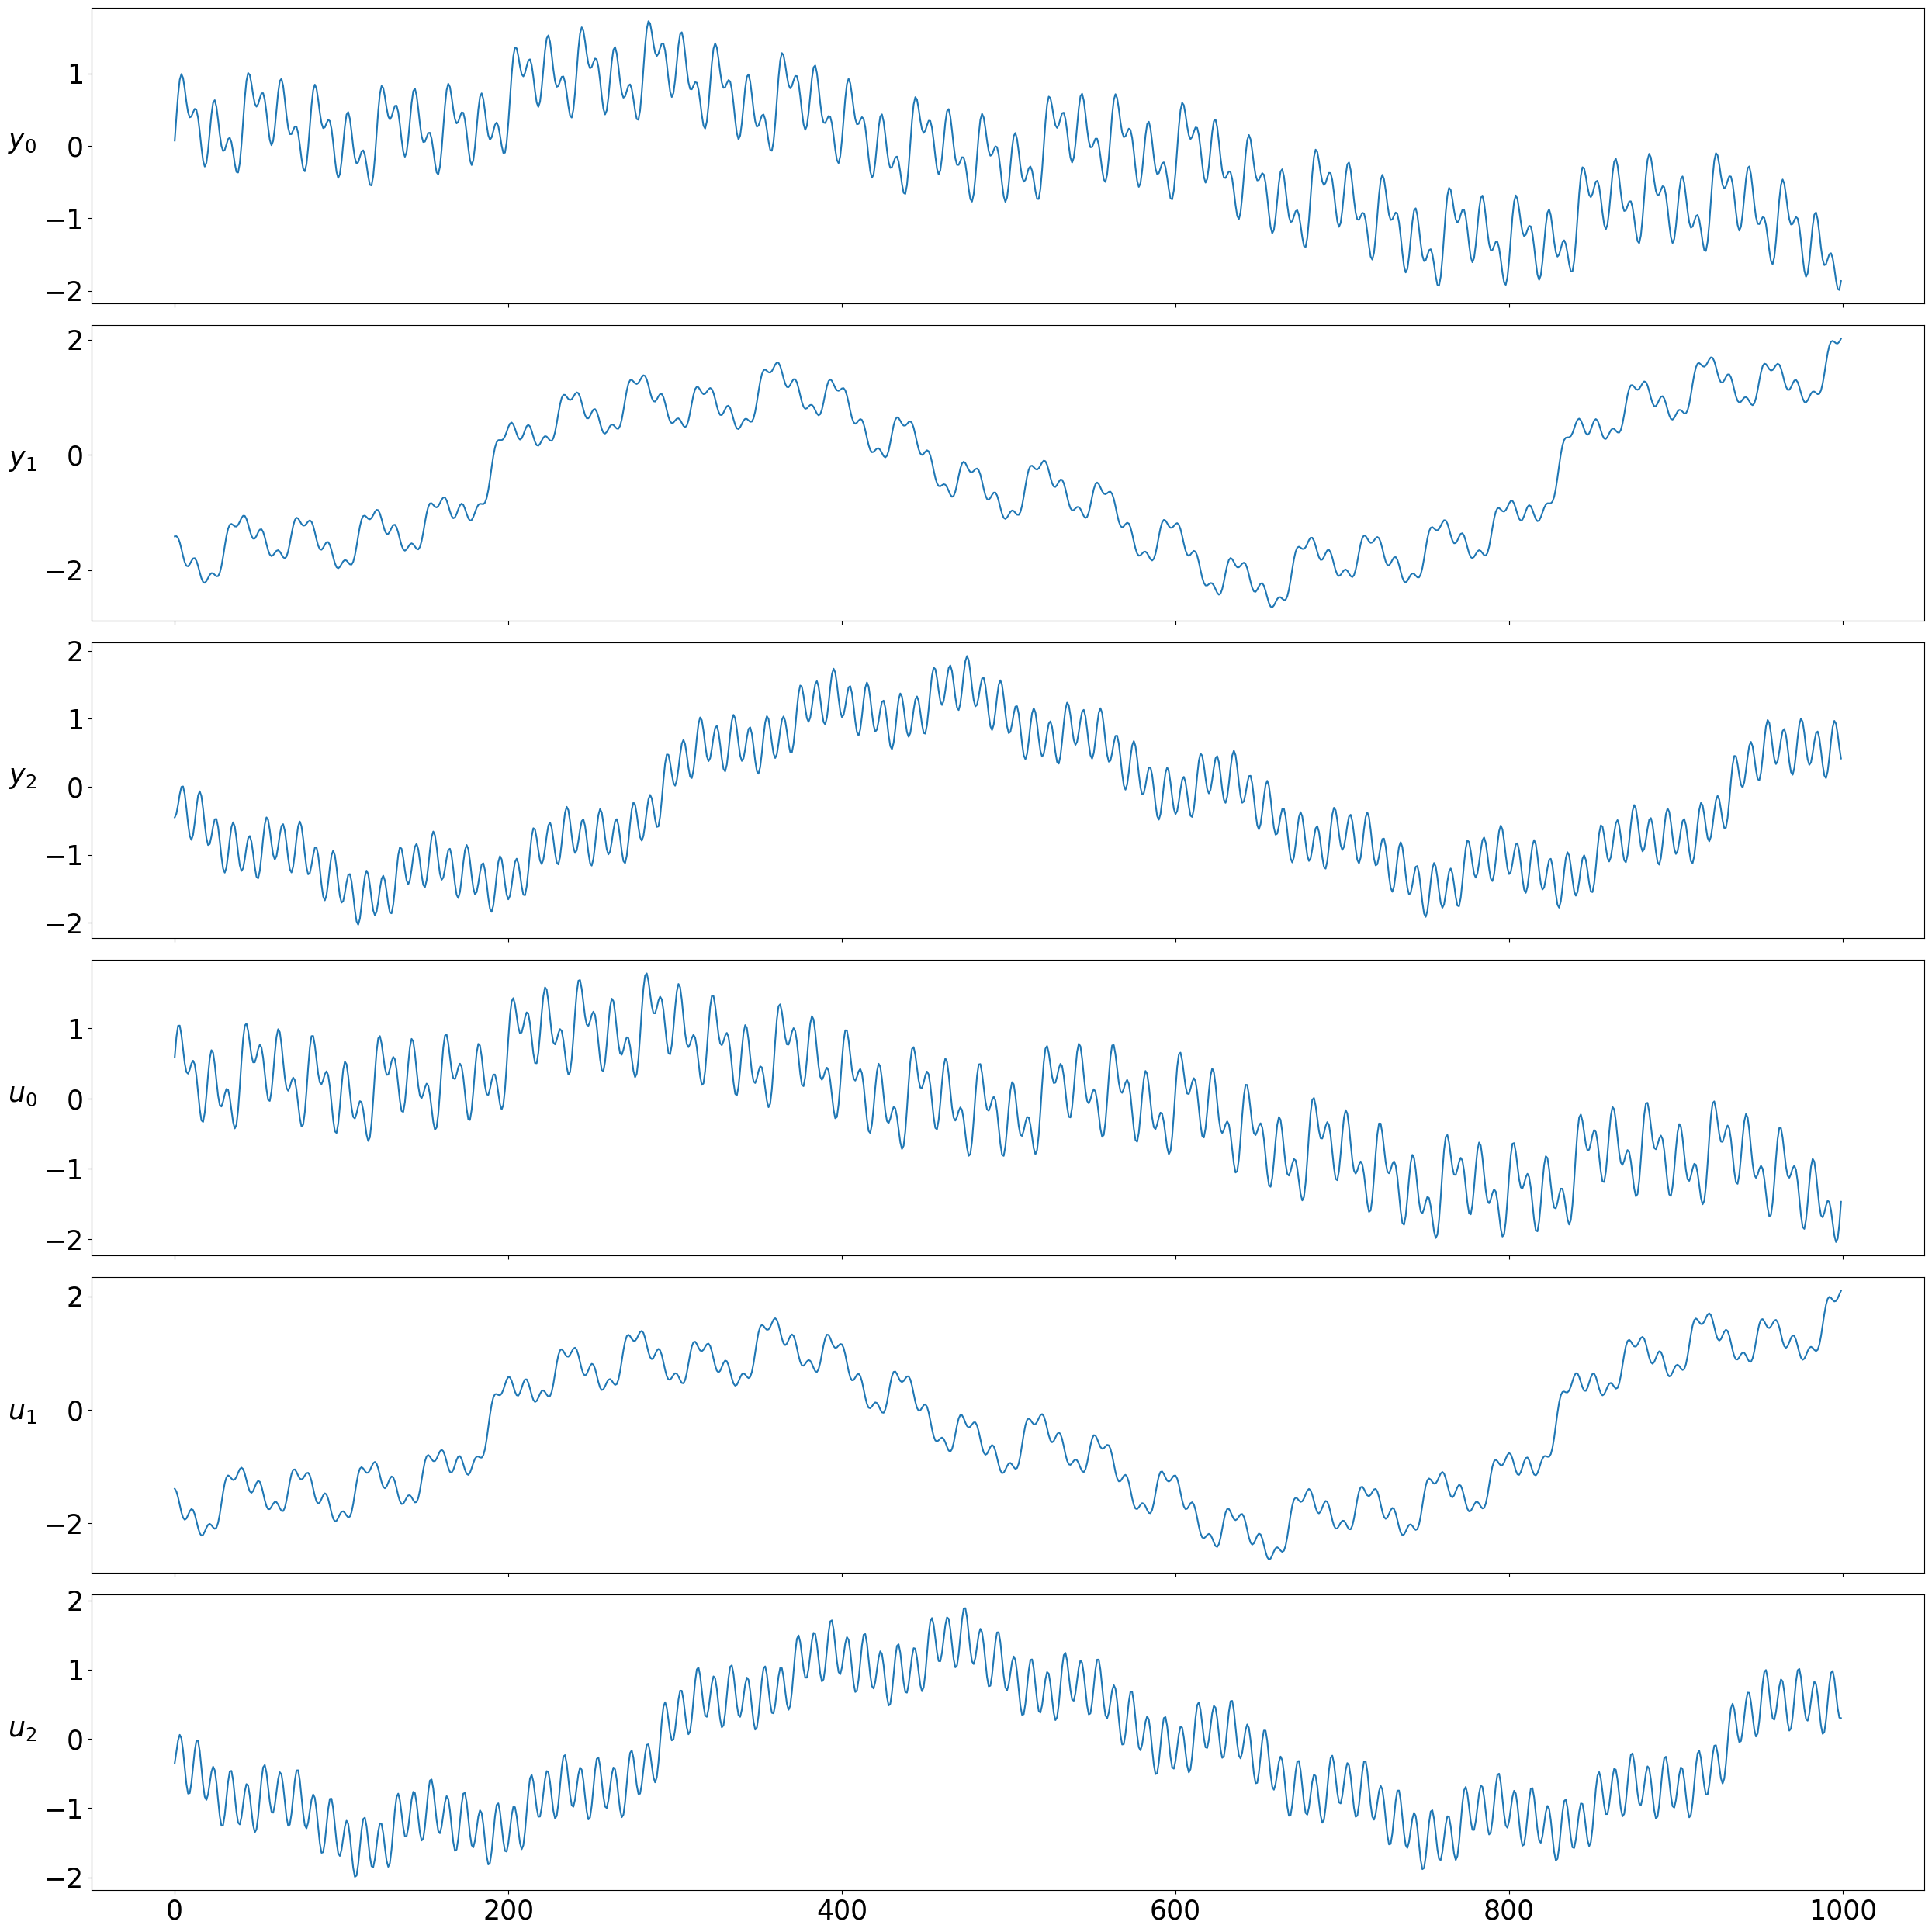

In [24]:
# obtain time series of the system to be controlled
train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]

# normalize the dataset
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
# show the training data
sys.show(train_data)

In [26]:
# Set up the data to be in samples of 10 contiguous time steps 
# (100 samples with 10 time steps each last dim is dimension of the measured variable)
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(100, -1)
    
# create dataloaders
from torch.utils.data import DataLoader
train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) 
                            for d in [train_dataset, dev_dataset]]

# Define the optimization problem

In [27]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')
# define system identification loss function
loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

# construct differentiable optimization problem in Neuromancer
obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

## Solve the system identification problem

In [28]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, dev_loader, 
                  optimizer=opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.13850335776805878
epoch: 1  train_loss: 0.13694468140602112
epoch: 2  train_loss: 0.1354312002658844
epoch: 3  train_loss: 0.1339615136384964
epoch: 4  train_loss: 0.13253390789031982
epoch: 5  train_loss: 0.13114644587039948
epoch: 6  train_loss: 0.12979717552661896
epoch: 7  train_loss: 0.12848445773124695
epoch: 8  train_loss: 0.12720675766468048
epoch: 9  train_loss: 0.12596265971660614
epoch: 10  train_loss: 0.1247507631778717
epoch: 11  train_loss: 0.12356992810964584
epoch: 12  train_loss: 0.12241898477077484
epoch: 13  train_loss: 0.12129691243171692
epoch: 14  train_loss: 0.1202029287815094
epoch: 15  train_loss: 0.11913640052080154
epoch: 16  train_loss: 0.11809694766998291
epoch: 17  train_loss: 0.11708435416221619
epoch: 18  train_loss: 0.11609853804111481
epoch: 19  train_loss: 0.1151396855711937
epoch: 20  train_loss: 0.11420805752277374
epoch: 21  train_loss: 0.11330392211675644
epoch: 22  train_loss: 0.1124277114868164
epoch: 23  train_loss: 0.11

epoch: 201  train_loss: 0.003423109417781234
epoch: 202  train_loss: 0.0033140373416244984
epoch: 203  train_loss: 0.0032092456240206957
epoch: 204  train_loss: 0.003108491888269782
epoch: 205  train_loss: 0.0030115500558167696
epoch: 206  train_loss: 0.0029182119760662317
epoch: 207  train_loss: 0.0028282839339226484
epoch: 208  train_loss: 0.00274158944375813
epoch: 209  train_loss: 0.002657964127138257
epoch: 210  train_loss: 0.0025772564113140106
epoch: 211  train_loss: 0.0024993291590362787
epoch: 212  train_loss: 0.0024240552447736263
epoch: 213  train_loss: 0.002351317787542939
epoch: 214  train_loss: 0.0022810082882642746
epoch: 215  train_loss: 0.0022130287252366543
epoch: 216  train_loss: 0.002147285733371973
epoch: 217  train_loss: 0.002083694329485297
epoch: 218  train_loss: 0.002022174885496497
epoch: 219  train_loss: 0.001962654059752822
epoch: 220  train_loss: 0.0019050611881539226
epoch: 221  train_loss: 0.0018493320094421506
epoch: 222  train_loss: 0.001795404125005006

epoch: 389  train_loss: 0.0001253389345947653
epoch: 390  train_loss: 0.0001246651663677767
epoch: 391  train_loss: 0.0001240021374542266
epoch: 392  train_loss: 0.0001233495568158105
epoch: 393  train_loss: 0.0001227071334142238
epoch: 394  train_loss: 0.0001220746198669076
epoch: 395  train_loss: 0.00012145185610279441
epoch: 396  train_loss: 0.0001208386238431558
epoch: 397  train_loss: 0.00012023466842947528
epoch: 398  train_loss: 0.00011963975703110918
epoch: 399  train_loss: 0.0001190537732327357
epoch: 400  train_loss: 0.00011847641872009262
epoch: 401  train_loss: 0.00011790754069807008
epoch: 402  train_loss: 0.00011734692088793963
epoch: 403  train_loss: 0.00011679438466671854
epoch: 404  train_loss: 0.0001162498228950426
epoch: 405  train_loss: 0.0001157129809143953
epoch: 406  train_loss: 0.00011518366954987869
epoch: 407  train_loss: 0.00011466183059383184
epoch: 408  train_loss: 0.00011414718755986542
epoch: 409  train_loss: 0.00011363963130861521
epoch: 410  train_loss:

epoch: 576  train_loss: 7.120471855159849e-05
epoch: 577  train_loss: 7.105775875970721e-05
epoch: 578  train_loss: 7.091135921655223e-05
epoch: 579  train_loss: 7.076557812979445e-05
epoch: 580  train_loss: 7.062036456773058e-05
epoch: 581  train_loss: 7.047570397844538e-05
epoch: 582  train_loss: 7.033167639747262e-05
epoch: 583  train_loss: 7.018812175374478e-05
epoch: 584  train_loss: 7.004517101449892e-05
epoch: 585  train_loss: 6.990277324803174e-05
epoch: 586  train_loss: 6.976093573030084e-05
epoch: 587  train_loss: 6.961964390939102e-05
epoch: 588  train_loss: 6.947889778530225e-05
epoch: 589  train_loss: 6.933871190994978e-05
epoch: 590  train_loss: 6.919904262758791e-05
epoch: 591  train_loss: 6.90599117660895e-05
epoch: 592  train_loss: 6.892126111779362e-05
epoch: 593  train_loss: 6.878321437397972e-05
epoch: 594  train_loss: 6.864564784336835e-05
epoch: 595  train_loss: 6.850861973362043e-05
epoch: 596  train_loss: 6.83720936649479e-05
epoch: 597  train_loss: 6.8236069637

epoch: 760  train_loss: 5.118796616443433e-05
epoch: 761  train_loss: 5.110716665512882e-05
epoch: 762  train_loss: 5.1026592700509354e-05
epoch: 763  train_loss: 5.0946280680364e-05
epoch: 764  train_loss: 5.086613600724377e-05
epoch: 765  train_loss: 5.078623871668242e-05
epoch: 766  train_loss: 5.0706548790913075e-05
epoch: 767  train_loss: 5.062703712610528e-05
epoch: 768  train_loss: 5.054776192991994e-05
epoch: 769  train_loss: 5.046874866820872e-05
epoch: 770  train_loss: 5.038991730543785e-05
epoch: 771  train_loss: 5.031131877331063e-05
epoch: 772  train_loss: 5.023290577810258e-05
epoch: 773  train_loss: 5.015471106162295e-05
epoch: 774  train_loss: 5.007674917578697e-05
epoch: 775  train_loss: 4.999894736101851e-05
epoch: 776  train_loss: 4.992139292880893e-05
epoch: 777  train_loss: 4.984403130947612e-05
epoch: 778  train_loss: 4.9766873416956514e-05
epoch: 779  train_loss: 4.968989742337726e-05
epoch: 780  train_loss: 4.9613197916187346e-05
epoch: 781  train_loss: 4.953664

epoch: 938  train_loss: 3.957705484936014e-05
epoch: 939  train_loss: 3.952419137931429e-05
epoch: 940  train_loss: 3.94714625144843e-05
epoch: 941  train_loss: 3.941885006497614e-05
epoch: 942  train_loss: 3.9366350392811e-05
epoch: 943  train_loss: 3.931391256628558e-05
epoch: 944  train_loss: 3.926162389689125e-05
epoch: 945  train_loss: 3.9209418901009485e-05
epoch: 946  train_loss: 3.9157330320449546e-05
epoch: 947  train_loss: 3.910535451723263e-05
epoch: 948  train_loss: 3.905346602550708e-05
epoch: 949  train_loss: 3.900171213899739e-05
epoch: 950  train_loss: 3.8950045563979074e-05
epoch: 951  train_loss: 3.889849176630378e-05
epoch: 952  train_loss: 3.884703619405627e-05
epoch: 953  train_loss: 3.8795671571278945e-05
epoch: 954  train_loss: 3.874441608786583e-05
epoch: 955  train_loss: 3.8693273381795734e-05
epoch: 956  train_loss: 3.864222890115343e-05
epoch: 957  train_loss: 3.859128264593892e-05
epoch: 958  train_loss: 3.854046008200385e-05
epoch: 959  train_loss: 3.848973

## Evaluate the learned NODE system model on 1000 time step rollout

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


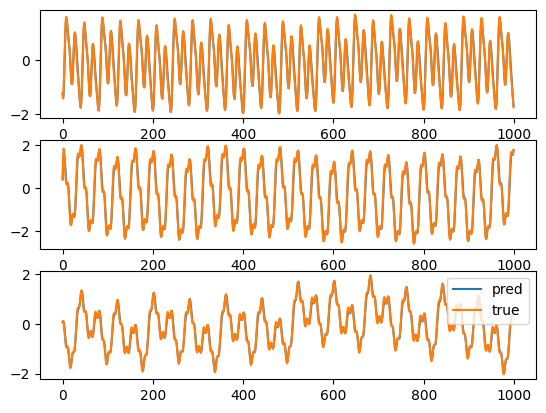

In [30]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), label='true')
plt.legend()

## Create a closed loop system using the system model and a parametrized control policy


In [33]:
nx, nu = sys.nx, sys.nu

class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node])
# cl_system.show()

## Sample dataset of control parameters 

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [34]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) 
                            for d in [train_dataset, dev_dataset]]

## Define objectives and of the optimal control problem

In [35]:
tru = variable('xn')[:, 1:, :]  # system states
ref = variable('R')             # reference 
u = variable('U')               # control action
# reference tracking objective
loss = (ref == tru) ^ 2
loss.update_name('loss')

# differentiable optimal control problem
obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

## Optimize the control policy

In [36]:
opt = optim.Adam(policy.parameters(), 0.01)
logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                  optimizer=opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.9137690663337708
epoch: 1  train_loss: 0.7752129435539246
epoch: 2  train_loss: 0.6369337439537048
epoch: 3  train_loss: 0.48806941509246826
epoch: 4  train_loss: 0.3404243588447571
epoch: 5  train_loss: 0.25918063521385193
epoch: 6  train_loss: 0.2633490264415741
epoch: 7  train_loss: 0.1811845302581787
epoch: 8  train_loss: 0.1328902244567871
epoch: 9  train_loss: 0.13147516548633575
epoch: 10  train_loss: 0.12120837718248367
epoch: 11  train_loss: 0.10390014946460724
epoch: 12  train_loss: 0.08635736256837845
epoch: 13  train_loss: 0.06776728481054306
epoch: 14  train_loss: 0.049649521708488464
epoch: 15  train_loss: 0.0381527915596962
epoch: 16  train_loss: 0.038232047110795975
epoch: 17  train_loss: 0.04492981359362602
epoch: 18  train_loss: 0.04683675989508629
epoch: 19  train_loss: 0.0392850898206234
epoch: 20  train_loss: 0.02700081095099449
epoch: 21  train_loss: 0.017318323254585266
epoch: 22  train_loss: 0.013535644859075546
epoch: 23  train_loss: 0.0

epoch: 185  train_loss: 0.00013710583152715117
epoch: 186  train_loss: 0.00013563466200139374
epoch: 187  train_loss: 0.00013419301831163466
epoch: 188  train_loss: 0.00013278002734296024
epoch: 189  train_loss: 0.0001313948887400329
epoch: 190  train_loss: 0.00013003693311475217
epoch: 191  train_loss: 0.00012870544742327183
epoch: 192  train_loss: 0.0001273997622774914
epoch: 193  train_loss: 0.00012611928104888648
epoch: 194  train_loss: 0.00012486331979744136
epoch: 195  train_loss: 0.00012363151472527534
epoch: 196  train_loss: 0.00012242306547705084
epoch: 197  train_loss: 0.00012123753549531102
epoch: 198  train_loss: 0.00012007409532088786
epoch: 199  train_loss: 0.00011893241753568873
epoch: 200  train_loss: 0.00011781190551118925
epoch: 201  train_loss: 0.0001167119771707803
epoch: 202  train_loss: 0.00011563222506083548
epoch: 203  train_loss: 0.0001145719870692119
epoch: 204  train_loss: 0.00011353088484611362
epoch: 205  train_loss: 0.00011250842362642288
epoch: 206  train

epoch: 370  train_loss: 4.25149301008787e-05
epoch: 371  train_loss: 4.234273365000263e-05
epoch: 372  train_loss: 4.217212335788645e-05
epoch: 373  train_loss: 4.200311013846658e-05
epoch: 374  train_loss: 4.183570126770064e-05
epoch: 375  train_loss: 4.166985672782175e-05
epoch: 376  train_loss: 4.150559107074514e-05
epoch: 377  train_loss: 4.134286427870393e-05
epoch: 378  train_loss: 4.118168726563454e-05
epoch: 379  train_loss: 4.1022049117600545e-05
epoch: 380  train_loss: 4.086391345481388e-05
epoch: 381  train_loss: 4.070728027727455e-05
epoch: 382  train_loss: 4.0552185964770615e-05
epoch: 383  train_loss: 4.039854320581071e-05
epoch: 384  train_loss: 4.024638110422529e-05
epoch: 385  train_loss: 4.0095717849908397e-05
epoch: 386  train_loss: 3.9946462493389845e-05
epoch: 387  train_loss: 3.979868779424578e-05
epoch: 388  train_loss: 3.965232099290006e-05
epoch: 389  train_loss: 3.950738755520433e-05
epoch: 390  train_loss: 3.9363854739349335e-05
epoch: 391  train_loss: 3.9221

epoch: 547  train_loss: 2.8525690140668303e-05
epoch: 548  train_loss: 2.8502170607680455e-05
epoch: 549  train_loss: 2.847896575985942e-05
epoch: 550  train_loss: 2.8456042855395935e-05
epoch: 551  train_loss: 2.843342736014165e-05
epoch: 552  train_loss: 2.8411104722181335e-05
epoch: 553  train_loss: 2.8389076760504395e-05
epoch: 554  train_loss: 2.8367345294100232e-05
epoch: 555  train_loss: 2.8345897590043023e-05
epoch: 556  train_loss: 2.83246990875341e-05
epoch: 557  train_loss: 2.8303798899287358e-05
epoch: 558  train_loss: 2.8283184292376973e-05
epoch: 559  train_loss: 2.8262866180739366e-05
epoch: 560  train_loss: 2.8242757252883166e-05
epoch: 561  train_loss: 2.8222946639289148e-05
epoch: 562  train_loss: 2.8203377951285802e-05
epoch: 563  train_loss: 2.81840893876506e-05
epoch: 564  train_loss: 2.816501546476502e-05
epoch: 565  train_loss: 2.814622530422639e-05
epoch: 566  train_loss: 2.8127682526246645e-05
epoch: 567  train_loss: 2.810940168274101e-05
epoch: 568  train_loss

epoch: 731  train_loss: 2.6952386178891174e-05
epoch: 732  train_loss: 2.695078910619486e-05
epoch: 733  train_loss: 2.6949230232276022e-05
epoch: 734  train_loss: 2.694771137612406e-05
epoch: 735  train_loss: 2.694623253773898e-05
epoch: 736  train_loss: 2.6944720957544632e-05
epoch: 737  train_loss: 2.694329305086285e-05
epoch: 738  train_loss: 2.6941863325191662e-05
epoch: 739  train_loss: 2.6940422685584053e-05
epoch: 740  train_loss: 2.6939078452414833e-05
epoch: 741  train_loss: 2.6937690563499928e-05
epoch: 742  train_loss: 2.6936371796182357e-05
epoch: 743  train_loss: 2.6935043933917768e-05
epoch: 744  train_loss: 2.693378883122932e-05
epoch: 745  train_loss: 2.6932502805721015e-05
epoch: 746  train_loss: 2.6931260435958393e-05
epoch: 747  train_loss: 2.6930016247206368e-05
epoch: 748  train_loss: 2.692881207622122e-05
epoch: 749  train_loss: 2.6927624276140705e-05
epoch: 750  train_loss: 2.6926443752017803e-05
epoch: 751  train_loss: 2.692530870262999e-05
epoch: 752  train_lo

epoch: 907  train_loss: 2.686367770365905e-05
epoch: 908  train_loss: 2.686361040105112e-05
epoch: 909  train_loss: 2.6863550374400802e-05
epoch: 910  train_loss: 2.6863468519877642e-05
epoch: 911  train_loss: 2.6863399398280308e-05
epoch: 912  train_loss: 2.6863366656471044e-05
epoch: 913  train_loss: 2.686327752599027e-05
epoch: 914  train_loss: 2.686323205125518e-05
epoch: 915  train_loss: 2.686317566258367e-05
epoch: 916  train_loss: 2.6863095627049915e-05
epoch: 917  train_loss: 2.686303196242079e-05
epoch: 918  train_loss: 2.6863013772526756e-05
epoch: 919  train_loss: 2.686295374587644e-05
epoch: 920  train_loss: 2.6862893719226122e-05
epoch: 921  train_loss: 2.6862811864702962e-05
epoch: 922  train_loss: 2.686277002794668e-05
epoch: 923  train_loss: 2.68627281911904e-05
epoch: 924  train_loss: 2.686267180251889e-05
epoch: 925  train_loss: 2.6862613594857976e-05
epoch: 926  train_loss: 2.6862580853048712e-05
epoch: 927  train_loss: 2.686253901629243e-05
epoch: 928  train_loss: 2

<All keys matched successfully>

## Evaluating the model on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

In [38]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
# test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torchdiffeq\_impl\misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
C:\Users\drgo694\AppData\Roaming\Python\Python310\site-packages\neuromancer\psl\base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'xn': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


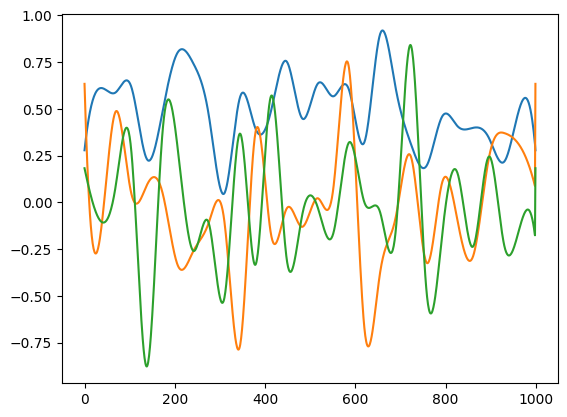

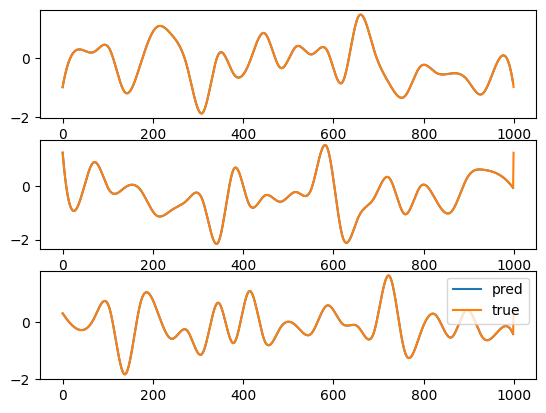

In [39]:
from neuromancer.psl.signals import sines, step, arma, spline
import numpy as np

plt.figure()
references = spline(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
plt.plot(references)
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), label='true')
plt.legend()
plt.savefig('control.png')
